**How to identify position players on a given date?**

**Problem:**
<br>
In daily fantasy baseball, a participant sets up their team against another player of their league. Some position players are stars and should play nearly all the time, but often a position is shared between other players on your roster. How do you choose which platooning player to start (especially if there is a limited sample size for the batter facing that pitcher)?

**Strategy:**
<br>
- Focus on features of the batter (e.g. historical batting average) and pitcher (e.g. historical ERA, WHIP) to predict whether the batter would output a hit (or HR, single, double, etc.) in a given batter-pitcher at-bat matchup.

- If you choose a given date (e.g. May 9), you know the starting pitcher a batter would face. Use data to build a model taht predicts how well a batter would do against the pitcher as a guide for a decision. (Lower priority: If the matchup for a particular batter-pitcher is small, find similar players to serve as a guide. Similar players can be found by using Erdos score.)

- How do I know if my strategy is improved over other models? Look at which player one would choose from a simple player ranking.

- Validation: Historical data

This notebook was created within my "insight" virtual environment.

**Inputs and outputs**

*Version 1:*
- Input: Two players under consideration for one position and a date of interest (2019 season for historical validation).
- Output: Player recommendation for that position with a predicted score.

*Version 2:*
- Input: A participant's player roster (e.g. 20 players)
- Output: A recommended lineup.

Order of features of product to incorporate: (still to be determined)

0.  Try a simple model where each at-bat batter-pitcher matchup is simply its own row and selected features are done. (DONE)
1.	Roster’s “basic” baseball statistics from 2018 season? Or 50 games (including previous season) - (minimum viable product level) (DONE)
2.	Specific matchup against that pitcher - “basic” baseball statistics
3.	Roster’s statcast statistics from last 50 games (including previous season) (DONE)
4.	Limit to more recent performance (last 100 at-bats games - dataframe for model does 200 rows)
5.	Weather, park effects, team defense, night/day, lineup order
6. Use batted ball characteristics as a feature of player and pitcher (launch angle average, launch speed average)
7.	Use of player similarity (lower priority)

Similar idea
https://community.fangraphs.com/the-outcome-machine-predicting-at-bats-before-they-happen/


EDA, do HR over time and by date for each player


**Product pitch**

I'm creating a fantasy baseball application that suggests players on a given day. Fantasy baseball has over 11 million participants with the winners of leagues collecting entry fees and host platforms receiving a commission. The projected market for fantasy baseball in 2020 is over 8 billion dollars. A participant's success depends in part on daily player selection. For player selection, participants must rely on their own research or use a site's recommendation, which uses black-box algorithms behind pay walls. I'm developing an alternative algorithm to assist in player selection to save participants time and expose the important features in player performance prediction.

# Ideas

- Will hit happen based on pitch count
- Use last 100 at-bats from the date of interest.
- Use Bayesian?
- EDA  - plot someone's hits over game-dates as a time series
- Look at the player's last 100 hits 

Other:
- Use all info for at-bat and then do backwards selection.

**Motivation: Learning analytics requries some skills I can develop here**

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [2]:
# Web/database stuff
# import urllib.request
# import xml.etree.ElementTree as ET
# from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [3]:
# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [4]:
# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [5]:
# Check versioning
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
print('sklearn: ', sklearn.__version__)

print('psycopg2: ', psycopg2.__version__)
print('sqlalchemy: ', sqlalchemy.__version__)
print('sqlalchemy_utils: ', sqlalchemy_utils.__version__)
print('multiprocess: ', multiprocess.__version__)

numpy:  1.17.4
pandas:  0.25.3
matplotlib:  3.1.1
seaborn:  0.9.0
sklearn:  0.22
psycopg2:  2.8.4 (dt dec pq3 ext lo64)
sqlalchemy:  1.3.11
sqlalchemy_utils:  0.36.1
multiprocess:  0.70.9


In [6]:
# Code formatting with Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [7]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup

<IPython.core.display.Javascript object>

# Database info

In [8]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

<IPython.core.display.Javascript object>

In [9]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


<IPython.core.display.Javascript object>

**Statcast data to database**
<br>
(done already, see previous versions of notebooks)

In [10]:
## create a database (if it doesn't exist)
# if not database_exists(engine.url):
#     create_database(engine.url)
# print(database_exists(engine.url))

<IPython.core.display.Javascript object>

In [11]:
# This is done, but note it's out of order

# date_list = [
#     ("2019-03-20", "2019-09-29"),
#     ("2018-03-29", "2018-10-01"),
#     ("2017-04-02", "2017-10-01"),
# ]

# Above gave **2,174,906** pitch-by-pitch results in the database

#     ("2016-04-03", "2016-10-02"),   # didn't get
#     ("2015-04-05", "2015-10-04"),   # didn't get


# for i, date_pair in enumerate(date_list):
#     if i < 1:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="replace")
#         print(date_pair, "replace mode")
#     else:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="append")
#         print(date_pair, "append mode")

<IPython.core.display.Javascript object>

In [12]:
# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

<IPython.core.display.Javascript object>

See other notebook for more info



In [13]:
# Get player id
sql_query = """
SELECT * FROM player_id;
"""

df_player_id = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [14]:
# Batting stats

sql_query = """
SELECT * FROM batting_stats18_wpid;
"""

df_batting_stats_wpid = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [15]:
df_batting_stats_wpid.shape

(955, 300)

<IPython.core.display.Javascript object>

In [16]:
df_batting_stats_wpid.head()

,index,index_x,Season,Name,Team,Age,G,AB,PA,H,...,first_name,index_y,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,63,2018.0,Mookie Betts,Red Sox,25.0,136.0,520.0,614.0,180.0,...,mookie,166,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,1,67,2018.0,Mike Trout,Angels,26.0,140.0,471.0,608.0,147.0,...,mike,1789,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0
2,2,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1417,ramirez,jose,542432,ramij004,ramirjo02,10171,2014.0,2018.0
3,68,38,2018.0,Ryder Jones,Giants,24.0,5.0,8.0,8.0,3.0,...,ryder,903,jones,ryder,624507,joner005,jonesry01,15982,2017.0,2018.0
4,3,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1418,ramirez,jose,608070,ramij003,ramirjo01,13510,2013.0,2019.0


<IPython.core.display.Javascript object>

In [17]:
# Pitching stats

sql_query = """
SELECT * FROM pitching_stats_wpid;
"""

df_pitching_stats_wpid = pd.read_sql_query(sql_query, con)
# Limit to 2018, like with baseball stats
df_pitching_stats_wpid = df_pitching_stats_wpid[
    df_pitching_stats_wpid["Season"] == 2018
].copy()

<IPython.core.display.Javascript object>

In [18]:
df_pitching_stats_wpid.shape

(789, 310)

<IPython.core.display.Javascript object>

In [19]:
df_pitching_stats_wpid.head()

,index,Season,Name,Team,Age,W,L,ERA,WAR,G,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
2,2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
4,1587,2018.0,Scott Kingery,Phillies,24.0,0.0,0.0,13.50,0.0,1.0,...,scott,kingery,kingery,scott,664068.0,kings001,kingesc01,17975.0,2018.0,2019.0
8,7,2018.0,Justin Verlander,Astros,35.0,16.0,9.0,2.52,6.6,34.0,...,justin,verlander,verlander,justin,434378.0,verlj001,verlaju01,8700.0,2005.0,2019.0
12,11,2018.0,Chris Sale,Red Sox,29.0,12.0,4.0,2.11,6.2,27.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0


<IPython.core.display.Javascript object>

# Notes

## Contingencies

1. What if player has day off? or no game is scheduled?
2. What if player or pitcher doesn't have minimum nback at-bats?
3. What if player doesn't have minimum nback at-bats against same or opposite handedness?

**Quora answer on number of plate appearances**
https://www.quora.com/How-many-at-bats-does-the-average-MLB-player-go-through-per-year

One direction to go with is how many PA wpild a player accumulate if theu were to play every day, and not rest. That would be around 725. Though that total is not really an average as few players exceed such a total each year.

A second number would be how many plate appearances bases on normal rest during a season if a player never was injured, about 145-150 games for position players other then the catcher and 110 to 115 for catchers. Those totals would be around 650 and 450 respectively.

Yet another way to answer this would be the number of PA by all position players on a roster that were supposed to be starters, but may receive less playing time due to injury or a team developing, trading for or discovering a better player. That would probably be closer to 400.

You could also thing about all position players on a team including bench players, if we include them our total now is closer to 200-250.

Yet another way to look at this is to include all players on the roster including pitcher who may notbat intentionally. Include them and tour total is closer to 100-120.

## Other ideas


- Look at probabilities, instead of looking for 1 (done - not strong)
- Aggregate per game (potentially something there - not sure)
- Look at Ty France
- Add in pitcher info 
- See what pitches they're hitting, then see how that matches with pitchers 
- Remember that ultimately, we want to see that we're picking the right player - someone who has a higher probability overall will be better choice


**Motivation: Learning analytics requries some skills I can develop here**

## Questions to ask

- Am I inputting handedness correctly? How to input values if they're transformed in the model? (L -1.41421356, R 0.70710678)
- Add pitcher specific ID as a factor?


## Things to fix

- Why is dataframe model going to <200 - cause of the day of separation.
- Standardize train-test before split

# Super simple - just use batter and pitchers as features

It should at least be better for prediction

In [125]:
# FUNCTION FOR GETTING STATCAST DATA

# Enter key_mlbam (Mike Trout, ESPN rank 1)
# pid_of_interest1 = 545361
# Enter key_mlbam (Jesse Winker, ESPN rank 280)
# pid_of_interest2 = 608385

# Enter key_mlbam (Mookie Betts, ESPN rank 2?)
# pid_of_interest1 = 605141
# # Enter key_mlbam (Leury Garcia, ESPN rank 300)
# pid_of_interest2 = 544725


# Reynolds and Garcia (668804, 544725)
# Bryan Reynolds (PIT)

pid_of_interest1 = 668804
pid_of_interest2 = 544725

date_of_interest = "'2019-09-04'"  # Note internal single quotes

no_total_ab_events = 5000


<IPython.core.display.Javascript object>

In [126]:
def get_sc_batter_df(player_id, date, n_ab_events):
    sql_query = (
        """
    (SELECT * FROM statcast 
    JOIN player_id ON statcast.batter=player_id.key_mlbam 
    WHERE statcast.batter= 
    """
        + str(player_id)
        + """
    AND statcast.game_date<=
    """
        + str(date)
        + """ 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up DESC 
    LIMIT
    """
        + str(n_ab_events)
        + ");"
    )

    # print(sql_query)

    df_sc_events = pd.read_sql_query(sql_query, con)
    df_sc_events.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df

    return df_sc_events

<IPython.core.display.Javascript object>

In [127]:
def get_predf4model(pid1, pid2):
    df_sc_events_b1 = get_sc_batter_df(pid_of_interest1, date_of_interest, 5000)
    df_sc_events_b2 = get_sc_batter_df(pid_of_interest2, date_of_interest, 5000)
    df_sc_events_b1b2 = pd.concat([df_sc_events_b1, df_sc_events_b2], axis=0)

    col2keep = [
        "game_date",
        "batter",
        "stand",
        "pitcher",
        "p_throws",
        "events",
        "inning_topbot",
    ]

    df_sc_events_b1b2_bpe = df_sc_events_b1b2[col2keep].copy()

    batter_code = {
        df_sc_events_b1b2_bpe["batter"].unique()[0]: 0,
        df_sc_events_b1b2_bpe["batter"].unique()[1]: 1,
    }

    df_sc_events_b1b2_bpe["batter"].replace(batter_code, inplace=True)

    df_sc_events_b1b2_bpe["stand"].replace({"L": 0, "R": 1}, inplace=True)

    pitcher_code = dict(
        zip(
            range(len(df_sc_events_b1b2_bpe["pitcher"].unique())),
            df_sc_events_b1b2_bpe["pitcher"].unique(),
        )
    )
    df_sc_events_b1b2_bpe["pitcher"].replace(pitcher_code, inplace=True)

    df_sc_events_b1b2_bpe["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    df_sc_events_b1b2_bpe["inning_topbot"].replace({"Top": 0, "Bot": 1}, inplace=True)

    events2count = ["walk", "single", "double", "triple", "home_run"]
    df_sc_events_b1b2_bpe["event_code"] = 0
    df_sc_events_b1b2_bpe.loc[
        df_sc_events_b1b2_bpe["events"].isin(events2count), "event_code"
    ] = 1

    return df_sc_events_b1b2_bpe

<IPython.core.display.Javascript object>

In [128]:
df_sc_b1b2 = get_predf4model(pid_of_interest1, pid_of_interest2)

<IPython.core.display.Javascript object>

In [129]:
df_sc_b1b2.head()

,game_date,batter,stand,pitcher,p_throws,events,inning_topbot,event_code
0,2019-09-04,0.0,0,570632.0,1,single,1,1
1,2019-09-04,0.0,1,543045.0,0,strikeout,1,0
2,2019-09-04,0.0,0,667498.0,1,field_out,1,0
3,2019-09-04,0.0,0,667498.0,1,double,1,1
4,2019-09-04,0.0,0,667498.0,1,field_error,1,0


<IPython.core.display.Javascript object>

In [130]:
df_sc_events_b1b2_bpe_4model = df_sc_b1b2[
    ["batter", "p_throws", "inning_topbot", "event_code"]
].copy()

<IPython.core.display.Javascript object>

In [131]:
df_sc_events_b1b2_bpe_4model.head()

,batter,p_throws,inning_topbot,event_code
0,0.0,1,1,1
1,0.0,0,1,0
2,0.0,1,1,0
3,0.0,1,1,1
4,0.0,1,1,0


<IPython.core.display.Javascript object>

## EDA

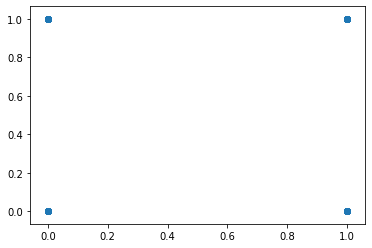

<IPython.core.display.Javascript object>

In [132]:
f, ax1 = plt.subplots()
ax1.scatter(
    df_sc_events_b1b2_bpe_4model["batter"], df_sc_events_b1b2_bpe_4model["event_code"]
)

## Logistic regression

In [133]:
def get_split_data(df4model, testsize):
    y = df4model["event_code"]
    X = df4model.iloc[:, :-1]

    # Scale features based on training data
    std_scale = StandardScaler()
    X_scale = std_scale.fit_transform(X)

    X_train_scale, X_test_scale, y_train, y_test = train_test_split(
        X_scale, y, test_size=testsize, random_state=19
    )

    return X_train_scale, X_test_scale, y_train, y_test

<IPython.core.display.Javascript object>

In [134]:
X_train_scale_b1b2, X_test_scale_b1b2, y_train_b1b2, y_test_b1b2 = get_split_data(
    df_sc_events_b1b2_bpe_4model, 0.4
)

<IPython.core.display.Javascript object>

In [135]:
def run_logreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression(class_weight="balanced")
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [136]:
# Run models
log_reg_b1b2, df_eval_b1b2 = run_logreg_model(
    X_train_scale_b1b2, y_train_b1b2, X_test_scale_b1b2, y_test_b1b2
)


<IPython.core.display.Javascript object>

In [137]:
df_eval_b1b2.head()

,test,pred,predprob
271,1,0,0.473426
203,0,0,0.473426
272,0,1,0.535937
157,1,1,0.537720
198,0,1,0.506387


<IPython.core.display.Javascript object>

In [138]:
print(metrics.classification_report(df_eval_b1b2["test"], df_eval_b1b2["pred"]))

              precision    recall  f1-score   support

           0       0.67      0.44      0.53       441
           1       0.32      0.55      0.41       213

    accuracy                           0.48       654
   macro avg       0.50      0.50      0.47       654
weighted avg       0.56      0.48      0.49       654



<IPython.core.display.Javascript object>

In [139]:
log_reg_b1b2.score(X_train_scale_b1b2, y_train_b1b2)

0.5056065239551478

<IPython.core.display.Javascript object>

In [140]:
log_reg_b1b2.score(X_test_scale_b1b2, y_test_b1b2)

0.4785932721712538

<IPython.core.display.Javascript object>

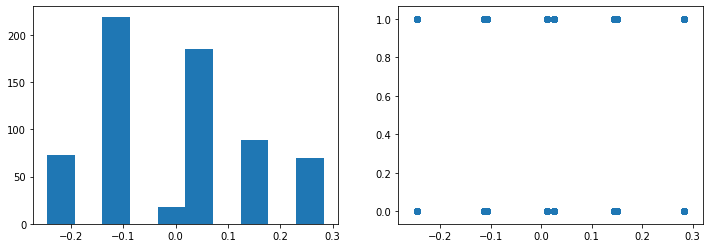

<IPython.core.display.Javascript object>

In [141]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(log_reg_b1b2.decision_function(X_test_scale_b1b2))
ax2.scatter(log_reg_b1b2.decision_function(X_test_scale_b1b2), y_test_b1b2)

In [142]:
X_test_scale_b1b2

array([[ 0.63611255, -1.54892492, -0.95279482],
       [ 0.63611255, -1.54892492, -0.95279482],
       [-1.57204885,  0.64560909,  1.04954391],
       ...,
       [ 0.63611255,  0.64560909,  1.04954391],
       [ 0.63611255, -1.54892492,  1.04954391],
       [ 0.63611255, -1.54892492, -0.95279482]])

<IPython.core.display.Javascript object>

In [143]:
log_reg_b1b2.coef_

array([[-0.11664244,  0.06012455, -0.06947827]])

<IPython.core.display.Javascript object>

## Validation

# Predict singles, home runs, etc.

In [145]:
def get_predf4model_detailed(pid1, pid2):
    df_sc_events_b1 = get_sc_batter_df(pid_of_interest1, date_of_interest, 5000)
    df_sc_events_b2 = get_sc_batter_df(pid_of_interest2, date_of_interest, 5000)
    df_sc_events_b1b2 = pd.concat([df_sc_events_b1, df_sc_events_b2], axis=0)

    col2keep = [
        "game_date",
        "batter",
        "stand",
        "pitcher",
        "p_throws",
        "events",
        "inning_topbot",
    ]

    df_sc_events_b1b2_bpe = df_sc_events_b1b2[col2keep].copy()

    batter_code = {
        df_sc_events_b1b2_bpe["batter"].unique()[0]: 0,
        df_sc_events_b1b2_bpe["batter"].unique()[1]: 1,
    }

    df_sc_events_b1b2_bpe["batter"].replace(batter_code, inplace=True)

    df_sc_events_b1b2_bpe["stand"].replace({"L": 0, "R": 1}, inplace=True)

    pitcher_code = dict(
        zip(
            range(len(df_sc_events_b1b2_bpe["pitcher"].unique())),
            df_sc_events_b1b2_bpe["pitcher"].unique(),
        )
    )
    df_sc_events_b1b2_bpe["pitcher"].replace(pitcher_code, inplace=True)

    df_sc_events_b1b2_bpe["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    df_sc_events_b1b2_bpe["inning_topbot"].replace({"Top": 0, "Bot": 1}, inplace=True)

    #     events2count = ["walk", "single", "double", "triple", "home_run"]
    #     df_sc_events_b1b2_bpe["event_code"] = 0
    #     df_sc_events_b1b2_bpe.loc[
    #         df_sc_events_b1b2_bpe["events"].isin(events2count), "event_code"
    #     ] = 1

    return df_sc_events_b1b2_bpe

<IPython.core.display.Javascript object>

In [146]:
df_sc_b1b2_det = get_predf4model_detailed(pid_of_interest1, pid_of_interest2)

<IPython.core.display.Javascript object>

In [147]:
df_sc_b1b2_det.head()

,game_date,batter,stand,pitcher,p_throws,events,inning_topbot
0,2019-09-04,0.0,0,570632.0,1,single,1
1,2019-09-04,0.0,1,543045.0,0,strikeout,1
2,2019-09-04,0.0,0,667498.0,1,field_out,1
3,2019-09-04,0.0,0,667498.0,1,double,1
4,2019-09-04,0.0,0,667498.0,1,field_error,1


<IPython.core.display.Javascript object>

# Add other features

# Valid for higher probability of predicting 1 identifies better player?

- Do models for each player and look at probabilities of outputting 1


## Input both batters and date

SQL query gets everything **before** the date. The validation and checking gets data on the day of.

In [683]:
# FUNCTION FOR GETTING STATCAST DATA

# Enter key_mlbam (Mike Trout, ESPN rank 1)
# pid_of_interest1 = 545361
# Enter key_mlbam (Jesse Winker, ESPN rank 280)
# pid_of_interest2 = 608385

# Enter key_mlbam (Mookie Betts, ESPN rank 2?)
pid_of_interest1 = 605141

# Enter key_mlbam (Leury Garcia, ESPN rank 300)
pid_of_interest2 = 544725

date_of_interest = "'2019-09-04'"  # Note internal single quotes

no_total_ab_events = 1000

# Note: SQL union of two different searches doesn't preserve order
# It's easier to make a dataframe for each player
# https://stackoverflow.com/questions/21181664/sql-server-union-but-keep-order/21181766
# ---------------------------------------------------

<IPython.core.display.Javascript object>

In [684]:
def get_sc_batter_df(player_id, date, n_ab_events):
    sql_query = (
        """
    (SELECT * FROM statcast 
    JOIN player_id ON statcast.batter=player_id.key_mlbam 
    WHERE statcast.batter= 
    """
        + str(player_id)
        + """
    AND statcast.game_date<=
    """
        + str(date)
        + """ 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up DESC 
    LIMIT
    """
        + str(n_ab_events)
        + ");"
    )

    # print(sql_query)

    df_sc_events = pd.read_sql_query(sql_query, con)
    df_sc_events.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df

    return df_sc_events

<IPython.core.display.Javascript object>

In [685]:
df_sc_events_b1 = get_sc_batter_df(pid_of_interest1, date_of_interest, 1000)
df_sc_events_b2 = get_sc_batter_df(pid_of_interest2, date_of_interest, 1000)

<IPython.core.display.Javascript object>

In [749]:
df_sc_events_b1.head(10)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SL,2019-09-24,84.1,-1.1610,6.2490,Ariel Jurado,605141.0,642558.0,home_run,hit_into_play_score,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,SI,2019-09-24,95.5,-1.6659,5.7278,Edinson Volquez,605141.0,450172.0,field_out,hit_into_play,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
2,FC,2019-09-23,86.0,-1.6035,5.4984,Emilio Pagan,605141.0,641941.0,single,hit_into_play_no_out,...,Strategic,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
3,FF,2019-09-23,93.9,1.4466,6.3134,Oliver Drake,605141.0,543118.0,field_out,hit_into_play,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
4,FF,2019-09-23,92.0,-0.3094,5.8277,Austin Pruitt,605141.0,643493.0,single,hit_into_play_no_out,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
5,FC,2019-09-23,85.3,-2.0997,6.2343,Chaz Roe,605141.0,475054.0,field_out,hit_into_play,...,Standard,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
6,FF,2019-09-23,95.5,1.5494,6.8716,Blake Snell,605141.0,605483.0,walk,ball,...,Standard,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
7,FC,2019-09-21,86.5,-1.5623,5.6209,Emilio Pagan,605141.0,641941.0,field_out,hit_into_play,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
8,FF,2019-09-21,96.0,-0.4617,6.6518,Nick Anderson,605141.0,623433.0,single,hit_into_play_no_out,...,Strategic,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
9,FT,2019-09-21,94.6,-1.7130,5.7539,Andrew Kittredge,605141.0,552640.0,force_out,hit_into_play,...,Standard,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0


<IPython.core.display.Javascript object>

In [687]:
df_sc_events_b2.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,FF,2019-09-04,91.9,2.8175,6.0013,Brad Hand,544725.0,543272.0,single,hit_into_play_no_out,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
1,KC,2019-09-04,83.2,-1.3917,5.7539,Shane Bieber,544725.0,669456.0,strikeout,swinging_strike_blocked,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
2,KC,2019-09-04,82.5,-1.5268,5.7392,Shane Bieber,544725.0,669456.0,force_out,hit_into_play,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
3,KC,2019-09-04,83.7,-1.4992,5.8262,Shane Bieber,544725.0,669456.0,strikeout,swinging_strike_blocked,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0
4,CH,2019-09-04,87.6,-1.6473,5.7523,Shane Bieber,544725.0,669456.0,single,hit_into_play_no_out,...,Standard,Standard,garcia,leury,544725,garcl004,garcile02,5913,2013.0,2019.0


<IPython.core.display.Javascript object>

In [688]:
def plot_events_over_time(sc_events_df, ev_list):
    df_temp = sc_events_df.copy()
    df_temp = df_temp[df_temp["game_date"].between("2019-04-01", "2019-09-09")]
    df_temp.reset_index(inplace=True)

    # Encode on-base events, including walks
    df_temp["event_code"] = 0
    df_temp.loc[df_temp["events"].isin(ev_list), "event_code"] = 1

    f, ax1 = plt.subplots()
    ax1.scatter(
        df_temp["game_date"],
        df_temp["event_code"] + np.random.normal(0, 0.01, len(df_temp)),
        facecolors="none",
        edgecolors="black",
    )

    # figure out date formatting
    # ax1.xticks(rotation=45)
    #     xlocs, xlabels = ax1.xticks()
    #     ax1.set_xticklabels(xlabels, rotation=45)  # to Rotate Xticks Label Text

    return df_temp[["events", "event_code"]].head(10)

<IPython.core.display.Javascript object>

,events,event_code
0,field_out,0
1,single,1
2,single,1
3,home_run,1
4,home_run,1
5,field_out,0
6,walk,1
7,field_out,0
8,field_out,0
9,field_out,0


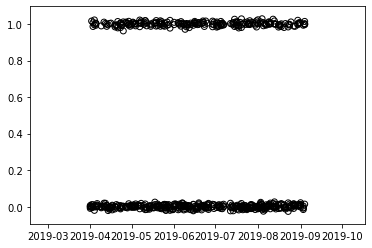

<IPython.core.display.Javascript object>

In [689]:
event_list = ["walk", "single", "double", "triple", "home_run"]
plot_events_over_time(df_sc_events_b1, event_list)

,events,event_code
0,single,1
1,strikeout,0
2,force_out,0
3,strikeout,0
4,single,1
5,strikeout,0
6,single,1
7,field_out,0
8,strikeout,0
9,strikeout,0


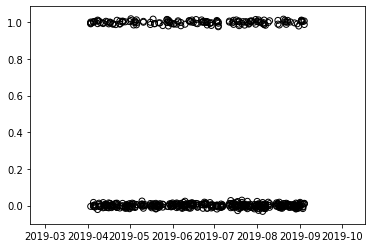

<IPython.core.display.Javascript object>

In [690]:
event_list = ["walk", "single", "double", "triple", "home_run"]
plot_events_over_time(df_sc_events_b2, event_list)

In [418]:
# def get_model_prob(df4model)

# Output probabilities of

<IPython.core.display.Javascript object>

In [760]:
def get_df4model(df, n_back_PA, m_size):
    """
    Function for getting summarized DF
    """
    # sample values -----------
    # n_back_PA = 100
    # df = df_sc_events.copy()
    # pid = pid_of_interest1
    # m_size = 200
    # -------------------------

    # Reset index so that code below works
    df.reset_index(inplace=True)

    # Encode on-base events, including walks
    ob_list = ["walk", "single", "double", "triple", "home_run"]
    df["event_code"] = 0
    df.loc[df["events"].isin(ob_list), "event_code"] = 1

    # Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak
    df["num_events_sum_nback"] = (
        df["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1]
    )

    # Percent of on-base events (overall)
    df["prop_events_nback"] = df["num_events_sum_nback"] / n_back_PA

    # Percent of on-base events against handedness of pitcher
    for i in df.index:
        p_throws = df["p_throws"].iloc[i]  # Get handedness of pitcher
        df_pt_throw = df[df["p_throws"] == p_throws]
        n_pt_events = df_pt_throw["event_code"].iloc[i : i + n_back_PA].sum()
        df.loc[i, "num_events_sum_nback_pt"] = n_pt_events
        df.loc[i, "prop_events_sum_nback_pt"] = n_pt_events / n_back_PA

    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
    ]

    df_4model = df[col4model].copy()
    df_4model_overall = df_4model.loc[:m_size]

    df_meta_w_model_overall = pd.merge(
        df[["game_date", "inning", "outs_when_up", "events", "player_name", "pitcher"]],
        df_4model_overall,
        left_index=True,
        right_index=True,
    )

    return df_meta_w_model_overall

<IPython.core.display.Javascript object>

In [692]:
df_sc_events_b1.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SI,2019-09-04,98.5,-1.6845,6.2965,Brusdar Graterol,605141.0,660813.0,field_out,hit_into_play,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,SL,2019-09-04,81.9,-1.3157,5.9479,Cody Stashak,605141.0,664054.0,single,hit_into_play_score,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
2,CH,2019-09-04,83.3,-3.5462,5.1358,Jose Berrios,605141.0,621244.0,single,hit_into_play_no_out,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
3,CU,2019-09-04,81.8,-3.6135,5.3624,Jose Berrios,605141.0,621244.0,home_run,hit_into_play_score,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
4,FF,2019-09-04,93.7,-3.5782,5.4881,Jose Berrios,605141.0,621244.0,home_run,hit_into_play_score,...,Infield shift,Standard,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0


<IPython.core.display.Javascript object>

In [761]:
df4model_b1 = get_df4model(df=df_sc_events_b1.copy(), n_back_PA=100, m_size=200)

<IPython.core.display.Javascript object>

In [762]:
df4model_b1.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.28,0.26
1,2019-09-24,8.0,2.0,field_out,Derek Holland,502706.0,0,L,0.29,0.26
2,2019-09-24,7.0,1.0,fielders_choice,Danny Hultzen,543343.0,0,L,0.29,0.26
3,2019-09-24,6.0,1.0,field_out,Kyle Hendricks,543294.0,0,R,0.29,0.33
4,2019-09-24,4.0,0.0,field_out,Kyle Hendricks,543294.0,0,R,0.29,0.33


<IPython.core.display.Javascript object>

In [763]:
print(df4model_b1.head())
print(df4model_b1.shape)

   game_date  inning  outs_when_up           events     player_name   pitcher  \
0 2019-09-25     1.0           1.0        field_out      Jon Lester  452657.0   
1 2019-09-24     8.0           2.0        field_out   Derek Holland  502706.0   
2 2019-09-24     7.0           1.0  fielders_choice   Danny Hultzen  543343.0   
3 2019-09-24     6.0           1.0        field_out  Kyle Hendricks  543294.0   
4 2019-09-24     4.0           0.0        field_out  Kyle Hendricks  543294.0   

   event_code p_throws  prop_events_nback  prop_events_sum_nback_pt  
0           0        L               0.28                      0.26  
1           0        L               0.29                      0.26  
2           0        L               0.29                      0.26  
3           0        R               0.29                      0.33  
4           0        R               0.29                      0.33  
(201, 10)


<IPython.core.display.Javascript object>

In [764]:
df4model_b2 = get_df4model(df=df_sc_events_b2.copy(), n_back_PA=100, m_size=200)

<IPython.core.display.Javascript object>

In [765]:
print(df4model_b2.head())
print(df4model_b2.shape)

   game_date  inning  outs_when_up                 events     player_name  \
0 2019-09-25     4.0           1.0              strikeout    Shane Bieber   
1 2019-09-25     2.0           1.0  strikeout_double_play    Shane Bieber   
2 2019-09-25     1.0           0.0               home_run    Shane Bieber   
3 2019-09-24     5.0           2.0              field_out  Mike Clevinger   
4 2019-09-24     3.0           2.0                 double  Mike Clevinger   

    pitcher  event_code p_throws  prop_events_nback  prop_events_sum_nback_pt  
0  669456.0           0        R               0.26                      0.26  
1  669456.0           0        R               0.27                      0.26  
2  669456.0           1        R               0.28                      0.26  
3  605182.0           0        R               0.27                      0.25  
4  605182.0           1        R               0.27                      0.25  
(201, 10)


<IPython.core.display.Javascript object>

In [697]:
print(pid_of_interest1, pid_of_interest2)

605141 544725


<IPython.core.display.Javascript object>

## EDA

Text(0, 0.5, 'event rate')

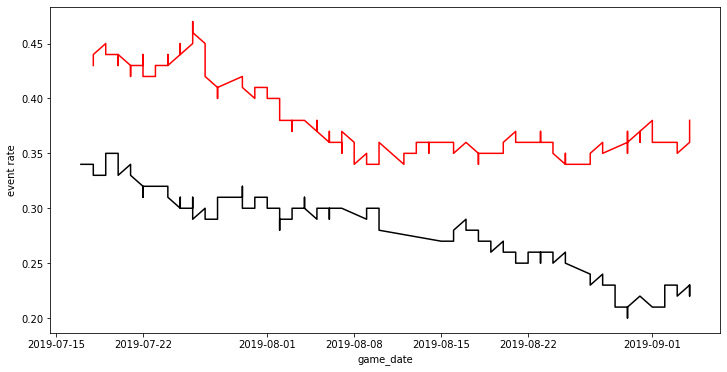

<IPython.core.display.Javascript object>

In [698]:
# Lineplot of each player

# Sanity checking that df is in order
f, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df4model_b1["game_date"], df4model_b1["prop_events_nback"], c='red', label='Player A (M. Trout)')
ax1.set_xlabel("game_date")

ax1.plot(df4model_b2["game_date"], df4model_b2["prop_events_nback"], c='black', label='Player B (L. Garcia)')
ax1.set_xlabel("game_date")
ax1.set_ylabel('event rate')


Text(0.5, 0, 'proportion of event')

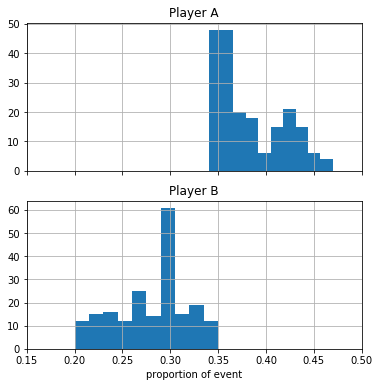

<IPython.core.display.Javascript object>

In [699]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
df4model_b1["prop_events_nback"].hist(ax=ax1)
ax1.set_xlim([0.15, 0.5])
ax1.set_title("Player A")

df4model_b2["prop_events_nback"].hist(ax=ax2)
ax2.set_xlim([0.15, 0.5])
ax2.set_title("Player B")
ax2.set_xlabel("proportion of event")

In [700]:
print(
    round(df4model_b1["prop_events_nback"].mean(), 3),
    round(df4model_b2["prop_events_nback"].mean(), 3),
)

0.382 0.279


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Player 2 (overall)')

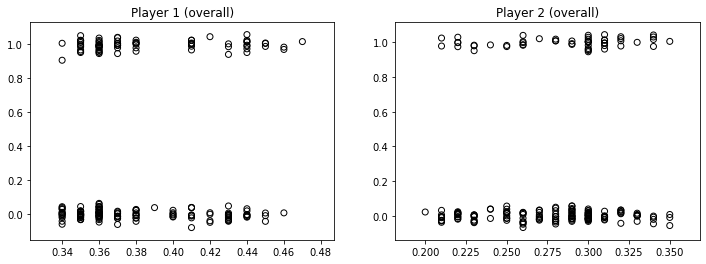

<IPython.core.display.Javascript object>

In [701]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(
    df4model_b1["prop_events_nback"],
    df4model_b1["event_code"] + np.random.normal(0, 0.025, len(df4model_b1)),
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("Player 1 (overall)")

ax2.scatter(
    df4model_b2["prop_events_nback"],
    df4model_b2["event_code"] + np.random.normal(0, 0.025, len(df4model_b2)),
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("Player 2 (overall)")

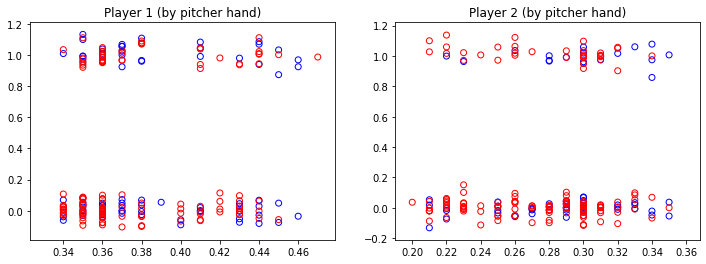

<IPython.core.display.Javascript object>

In [702]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
c_hand_list = ["blue", "red"]

for i, hand in enumerate(["L", "R"]):
    df4model_b1_hand = df4model_b1[df4model_b1["p_throws"] == hand].copy()
    df4model_b2_hand = df4model_b2[df4model_b2["p_throws"] == hand].copy()

    ax1.scatter(
        df4model_b1_hand["prop_events_nback"],
        df4model_b1_hand["event_code"]
        + +np.random.normal(0, 0.05, len(df4model_b1_hand)),
        facecolors="none",
        edgecolors=c_hand_list[i],
    )
    ax1.set_title("Player 1 (by pitcher hand)")

    ax2.scatter(
        df4model_b2_hand["prop_events_nback"],
        df4model_b2_hand["event_code"]
        + np.random.normal(0, 0.05, len(df4model_b2_hand)),
        facecolors="none",
        edgecolors=c_hand_list[i],
    )
    ax2.set_title("Player 2 (by pitcher hand)")

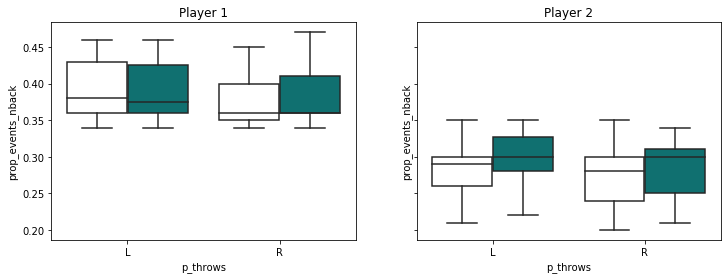

<IPython.core.display.Javascript object>

In [703]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.boxplot(
    x="p_throws",
    hue="event_code",
    y="prop_events_nback",
    data=df4model_b1,
    palette=["w", "teal"],
    order=["L", "R"],
    hue_order=[0, 1],
    ax=ax1,
)
ax1.set_title("Player 1")
ax1.get_legend().remove()

sns.boxplot(
    x="p_throws",
    hue="event_code",
    y="prop_events_nback",
    data=df4model_b2,
    palette=["w", "teal"],
    order=["L", "R"],
    hue_order=[0, 1],
    ax=ax2,
)
ax2.set_title("Player 2")
ax2.get_legend().remove()

In [707]:
groupA1_vals = df4model_b1.loc[(df4model_b1["p_throws"] == 'L') & (df4model_b1["event_code"] == 0), "prop_events_nback"]
groupA2_vals = df4model_b1.loc[(df4model_b1["p_throws"] == 'L') & (df4model_b1["event_code"] == 1), "prop_events_nback"]

mw_p_A = mannwhitneyu(groupA1_vals, groupA2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_A = ttest_ind(groupA1_vals, groupA2_vals, equal_var=False)[1]
print("Player A vs. LHP, MW: ", mw_p_A, "Player A vs. LHP, t-test: ", ttest_p_A)

groupB1_vals = df4model_b1.loc[(df4model_b1["p_throws"] == 'R') & (df4model_b1["event_code"] == 0), "prop_events_nback"]
groupB2_vals = df4model_b1.loc[(df4model_b1["p_throws"] == 'R') & (df4model_b1["event_code"] == 1), "prop_events_nback"]

mw_p_B = mannwhitneyu(groupB1_vals, groupB2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_B = ttest_ind(groupB1_vals, groupB2_vals, equal_var=False)[1]
print("Player A vs. RHP, MW: ", mw_p_B, "Player A vs. RHP, t-test: ", ttest_p_B)


Player A vs. LHP, MW:  0.3932740428366445 Player A vs. LHP, t-test:  0.8485847091388969
Player A vs. RHP, MW:  0.05342558818436174 Player A vs. RHP, t-test:  0.22370429388275034


<IPython.core.display.Javascript object>

In [708]:
groupA1_vals = df4model_b2.loc[(df4model_b2["p_throws"] == 'L') & (df4model_b2["event_code"] == 0), "prop_events_nback"]
groupA2_vals = df4model_b2.loc[(df4model_b2["p_throws"] == 'L') & (df4model_b2["event_code"] == 1), "prop_events_nback"]

mw_p_A = mannwhitneyu(groupA1_vals, groupA2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_A = ttest_ind(groupA1_vals, groupA2_vals, equal_var=False)[1]
print("Player B vs. LHP, MW: ", mw_p_A, "Player B vs. LHP, t-test: ", ttest_p_A)

groupb2_vals = df4model_b2.loc[(df4model_b2["p_throws"] == 'R') & (df4model_b2["event_code"] == 0), "prop_events_nback"]
groupB2_vals = df4model_b2.loc[(df4model_b2["p_throws"] == 'R') & (df4model_b2["event_code"] == 1), "prop_events_nback"]

mw_p_B = mannwhitneyu(groupb2_vals, groupB2_vals)[1]
# Welch's test (does not assume variances are equal)
ttest_p_B = ttest_ind(groupb2_vals, groupB2_vals, equal_var=False)[1]
print("Player B vs. RHP, MW: ", mw_p_B, "Player B vs. RHP, t-test: ", ttest_p_B)


Player B vs. LHP, MW:  0.08498558771377174 Player B vs. LHP, t-test:  0.1949851865051548
Player B vs. RHP, MW:  0.17369298762047164 Player B vs. RHP, t-test:  0.522985948121288


<IPython.core.display.Javascript object>

## Logistic regression

### Separate "day of" from "pre-date" data

In [766]:
df4model_dayof_b1 = df4model_b1[df4model_b1["game_date"] == date_of_interest].copy()
df4model_dayof_b1

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.28,0.26


<IPython.core.display.Javascript object>

In [767]:
df4model_dayof_b2 = df4model_b2[df4model_b2["game_date"] == date_of_interest].copy()
df4model_dayof_b2

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-25,4.0,1.0,strikeout,Shane Bieber,669456.0,0,R,0.26,0.26
1,2019-09-25,2.0,1.0,strikeout_double_play,Shane Bieber,669456.0,0,R,0.27,0.26
2,2019-09-25,1.0,0.0,home_run,Shane Bieber,669456.0,1,R,0.28,0.26


<IPython.core.display.Javascript object>

In [768]:
col4model = ["event_code", "p_throws", "prop_events_nback", "prop_events_sum_nback_pt"]
df4model_b1_lim = df4model_b1.loc[
    df4model_b1["game_date"] < date_of_interest, col4model
].copy()

df4model_b2_lim = df4model_b2.loc[
    df4model_b2["game_date"] < date_of_interest, col4model
].copy()


# df4model_b1_lim = df4model_b1[col4model].copy()
# df4model_b2_lim = df4model_b2[col4model].copy()

<IPython.core.display.Javascript object>

In [769]:
pd.concat([df4model_b1_lim.head(), df4model_b2_lim.head()], axis=1)

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
1,0.0,L,0.29,0.26,NaN,NaN,NaN,NaN
2,0.0,L,0.29,0.26,NaN,NaN,NaN,NaN
3,0.0,R,0.29,0.33,0.0,R,0.27,0.25
4,0.0,R,0.29,0.33,1.0,R,0.27,0.25
5,0.0,R,0.29,0.33,0.0,R,0.27,0.25
6,NaN,NaN,NaN,NaN,1.0,R,0.28,0.25
7,NaN,NaN,NaN,NaN,0.0,R,0.27,0.24


<IPython.core.display.Javascript object>

In [770]:
# FUNCTION TO REPLACE CATEGORICAL INPUT
df4model_b1_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
df4model_b2_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

<IPython.core.display.Javascript object>

In [210]:
# f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))

# df4model_b1_lim["prop_events_nback"].hist(ax=ax1)
# ax1.set_title("overall events, player 1")

# df_temp = df4model_b1_lim[df4model_b1_lim["p_throws"] == 0]
# df_temp["prop_events_nback"].hist(ax=ax2)
# ax2.set_title("events against left-handers, player 1")

# df_temp = df4model_b1_lim[df4model_b1_lim["p_throws"] == 1]
# df_temp["prop_events_nback"].hist(ax=ax3)
# ax3.set_title("events against right-handers, player 1")

# df4model_p2["prop_events_nback"].hist(ax=ax4)
# ax4.set_title("overall events, player 2")

# df_temp = df4model_p2[df4model_p2["p_throws"] == 0]
# df_temp["prop_events_nback"].hist(ax=ax5)
# ax5.set_title("events against left-handers, player 2")

# df_temp = df4model_p2[df4model_p2["p_throws"] == 1]
# df_temp["prop_events_nback"].hist(ax=ax6)
# ax6.set_title("events against right-handers, player 2")

# plt.tight_layout()

<IPython.core.display.Javascript object>

In [717]:
def get_split_data(df4model, testsize):
    y = df4model["event_code"]
    X = df4model.iloc[:, 1::]

    # Scale features based on training data
    std_scale = StandardScaler()
    X_scale = std_scale.fit_transform(X)

    X_train_scale, X_test_scale, y_train, y_test = train_test_split(
        X_scale, y, test_size=testsize, random_state=19
    )

    return X_train_scale, X_test_scale, y_train, y_test

<IPython.core.display.Javascript object>

In [718]:
df4model_b1_lim.shape

(196, 4)

<IPython.core.display.Javascript object>

In [719]:
df4model_b2_lim.shape

(196, 4)

<IPython.core.display.Javascript object>

In [720]:
X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
    df4model_b1_lim, 0.4
)
X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
    df4model_b2_lim, 0.4
)

<IPython.core.display.Javascript object>

In [721]:
print(X_train_scale_b1.shape, X_test_scale_b1.shape, y_train_b1.shape, y_test_b1.shape)
print(X_train_scale_b2.shape, X_test_scale_b2.shape, y_train_b2.shape, y_test_b2.shape)

(117, 3) (79, 3) (117,) (79,)
(117, 3) (79, 3) (117,) (79,)


<IPython.core.display.Javascript object>

In [722]:
def run_logreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression()
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [723]:
# Run models
log_reg_b1, df_eval_b1 = run_logreg_model(
    X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
)

log_reg_b2, df_eval_b2 = run_logreg_model(
    X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
)

<IPython.core.display.Javascript object>

In [728]:
df_eval_b2

,test,pred,predprob
36,0,0,0.234481
155,0,0,0.198830
149,1,0,0.227086
42,0,0,0.272737
141,0,0,0.250035
...,...,...,...
182,0,0,0.257748
190,0,1,0.509997
88,0,0,0.155930
73,0,0,0.242173


<IPython.core.display.Javascript object>

In [670]:
pd.concat([df_eval_b1.reset_index().head(), df_eval_b2.reset_index().head()], axis=1)

,index,test,pred,predprob,index,test,pred,predprob
0,33,0,0,0.375885,34,0,0,0.255355
1,77,0,0,0.307078,78,0,0,0.237118
2,149,1,0,0.245903,149,0,0,0.347667
3,39,1,0,0.386789,40,0,0,0.256470
4,84,0,0,0.304194,85,0,0,0.250267


<IPython.core.display.Javascript object>

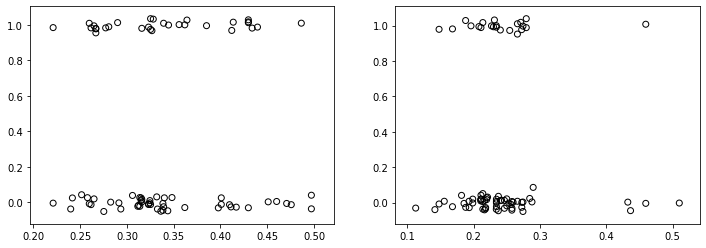

<IPython.core.display.Javascript object>

In [729]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(
    df_eval_b1["predprob"],
    df_eval_b1["test"] + np.random.normal(0, 0.025, len(df_eval_b1)),
    facecolors="none",
    edgecolors="black",
)

ax2.scatter(
    df_eval_b2["predprob"],
    df_eval_b2["test"] + np.random.normal(0, 0.025, len(df_eval_b2)),
    facecolors="none",
    edgecolors="black",
)

In [730]:
print("Player 1 coefficients: ", log_reg_b1.coef_)
print("Player 2 coefficients: ", log_reg_b2.coef_)

Player 1 coefficients:  [[-0.18090405  0.03527459  0.19690786]]
Player 2 coefficients:  [[-0.03456852  0.34511474 -0.40894548]]


<IPython.core.display.Javascript object>

In [456]:
# INPUT HANDEDNESS CORRECTLY - it's transformed

# L -1.41421356
# R 0.70710678


<IPython.core.display.Javascript object>

## Output for new case - check this

In [731]:
# "Day of" data was extracted above

# col4model = ["event_code", "p_throws", "prop_events_nback", "prop_events_sum_nback_pt"]
# This variable was already assigned above - just put here as a reminder

# Get up to last 3 at-bats for the input
df4model_dayof_4model_b1 = df4model_dayof_b1[col4model].iloc[-3:, :].copy()
df4model_dayof_4model_b2 = df4model_dayof_b2[col4model].iloc[-3:, :].copy()

# replace categorical input
df4model_dayof_4model_b1["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
df4model_dayof_4model_b2["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

<IPython.core.display.Javascript object>

### Predict and compare to real performance

In [734]:
df4model_dayof_4model_b1

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
2,1,1,0.38,0.33
3,1,1,0.37,0.32
4,1,1,0.36,0.31


<IPython.core.display.Javascript object>

In [735]:
df4model_dayof_4model_b2

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
2,0,1,0.22,0.24
3,0,1,0.23,0.25
4,1,1,0.23,0.24


<IPython.core.display.Javascript object>

In [746]:
def return_series_of_player_prediction(
    df4model_dayof_b1, df4model_dayof_b2, log_reg_b1, log_reg_b2
):
    s_new_case = pd.Series()

    df4model_dayof_b1 = df4model_dayof_4model_b1.copy()
    df4model_dayof_b2 = df4model_dayof_4model_b2.copy()

    # actual performance
    s_new_case["actual_performance_batterA"] = df4model_dayof_b1.reset_index()[
        "event_code"
    ].mean()
    s_new_case["actual_performance_batterB"] = df4model_dayof_b2.reset_index()[
        "event_code"
    ].mean()

    # ADD VARIANCE - TBD
    s_new_case["pred_var_batterA"] = None
    s_new_case["pred_var_batterB"] = None

    # vs actual pitcher
    s_new_case["pred_vs_gamepitcher_batterA"] = log_reg_b1.predict_proba(
        df4model_dayof_b1.iloc[:, 1:]
    )[:, 1].mean()

    s_new_case["pred_vs_gamepitcher_batterB"] = log_reg_b2.predict_proba(
        df4model_dayof_b2.iloc[:, 1:]
    )[:, 1].mean()

    # Prediction
    if (
        s_new_case["pred_vs_gamepitcher_batterA"]
        > s_new_case["pred_vs_gamepitcher_batterB"]
    ):
        predict_for_day = "predict_A"
    else:
        predict_for_day = "predict_B"

    # Actual case
    if (
        s_new_case["actual_performance_batterA"]
        > s_new_case["actual_performance_batterB"]
    ):
        actual_for_day = "actual_A"
    else:
        actual_for_day = "actual_B"

    validation_entries = (
        date_of_interest,
        pid_of_interest1,
        pid_of_interest2,
        predict_for_day,
        actual_for_day,
    )

    return s_new_case, validation_entries

<IPython.core.display.Javascript object>

In [655]:
# May not need
# def return_df_of_player_prediction(df4model_dayof_b1, df4model_dayof_b2):

#     df_new_case = pd.DataFrame()

#     # actual performance
#     df_new_case["actual_performance_batterA"] = df4model_dayof_b1.reset_index()[
#         "event_code"
#     ]
#     df_new_case["actual_performance_batterB"] = df4model_dayof_b2.reset_index()[
#         "event_code"
#     ]

#     # ADD VARIANCE - TBD
#     df_new_case["pred_var_batterA"] = None
#     df_new_case["pred_var_batterB"] = None

#     # vs actual pitcher
#     df_new_case["pred_vs_gamepitcher_batterA"] = log_reg_b1.predict_proba(
#         df4model_dayof_b1.iloc[:, 1:]
#     )[:, 1]

#     df_new_case["pred_vs_gamepitcher_batterB"] = log_reg_b2.predict_proba(
#         df4model_dayof_b2.iloc[:, 1:]
#     )[:, 1]

#     #     # vs LHP pitcher - player A
#     #     df_temp_left = df4model_dayof_b1.iloc[:, 1:]
#     #     df_temp_left.loc[:, "p_throws"] = [0] * len(df4model_dayof_4model_b1)
#     #     df_new_case["pred_vs_LHP_batterA"] = log_reg_b1.predict_proba(df_temp_left)[:, 1]

#     #     # vs LHP pitcher - player B
#     #     df_temp_left = df4model_dayof_b2.iloc[:, 1:]
#     #     df_temp_left.loc[:, "p_throws"] = [0] * len(df4model_dayof_b2)
#     #     df_new_case["pred_vs_LHP_batterB"] = log_reg_b2.predict_proba(df_temp_left)[:, 1]

#     #     # vs RHP pitcher - player A
#     #     df_temp_left = df4model_dayof_b1.iloc[:, 1:]
#     #     df_temp_left.loc[:, "p_throws"] = [1] * len(df4model_dayof_b1)
#     #     df_new_case["pred_vs_RHP_batterA"] = log_reg_b1.predict_proba(df_temp_left)[:, 1]

#     #     # vs RHP pitcher - player B
#     #     df_temp_left = df4model_dayof_b2.iloc[:, 1:]
#     #     df_temp_left.loc[:, "p_throws"] = [1] * len(df4model_dayof_b2)
#     #     df_new_case["pred_vs_RHP_batterB"] = log_reg_b2.predict_proba(df_temp_left)[:, 1]

#     # Prediction
#     if (
#         df_new_case["pred_vs_gamepitcher_batterA"].mean()
#         > df_new_case["pred_vs_gamepitcher_batterB"].mean()
#     ):
#         predict_for_day = "predict_A"
#     else:
#         predict_for_day = "predict_B"

#     # Actual case
#     if (
#         df_new_case["actual_performance_batterA"].mean()
#         > df_new_case["actual_performance_batterB"].mean()
#     ):
#         actual_for_day = "actual_A"
#     else:
#         actual_for_day = "actual_B"

#     validation_entries = (
#         date_of_interest,
#         pid_of_interest1,
#         pid_of_interest2,
#         predict_for_day,
#         actual_for_day,
#     )

#     return df_new_case, validation_entries

<IPython.core.display.Javascript object>

In [737]:
return_series_of_player_prediction(
    df4model_dayof_4model_b1, df4model_dayof_4model_b2, log_reg_b1, log_reg_b2
)

(actual_performance_batterA            1
 actual_performance_batterB     0.333333
 pred_var_batterA                   None
 pred_var_batterB                   None
 pred_vs_gamepitcher_batterA    0.310539
 pred_vs_gamepitcher_batterB    0.231098
 dtype: object, ("'2019-09-04'", 605141, 544725, 'predict_A', 'actual_A'))

<IPython.core.display.Javascript object>

## Assessments

In [738]:
# Look at r2 value  - predicts variance - but there's lots of zeros

log_reg_p1.score(X_train_scale_p1, y_train_p1)

0.625

<IPython.core.display.Javascript object>

In [739]:
log_reg_p1.score(X_test_scale_p1, y_test_p1)

0.6172839506172839

<IPython.core.display.Javascript object>

In [740]:
print(metrics.classification_report(y_test_p1, y_pred_p1))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       0.00      0.00      0.00        31

    accuracy                           0.62        81
   macro avg       0.31      0.50      0.38        81
weighted avg       0.38      0.62      0.47        81



/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

In [741]:
log_reg_p2.score(X_train_scale_p2, y_train_p2)

0.725

<IPython.core.display.Javascript object>

In [742]:
log_reg_p2.score(X_test_scale_p2, y_test_p2)

0.7283950617283951

<IPython.core.display.Javascript object>

In [743]:
print(metrics.classification_report(y_test_p2, y_pred_p2))

              precision    recall  f1-score   support

           0       0.75      0.97      0.84        61
           1       0.00      0.00      0.00        20

    accuracy                           0.73        81
   macro avg       0.37      0.48      0.42        81
weighted avg       0.56      0.73      0.63        81



<IPython.core.display.Javascript object>

In [ ]:
# Add validation for similar players and different dates
# Use a set of outfielders and dates

# VALIDATION with multiple dates

## Easy case - one player excellent, one not as good

In [747]:
# Betts and Garcia (605141, 544725)
pid1 = 605141
pid2 = 544725

# (43 dates)

date_list = ["'2019-07-16'",
 "'2019-07-17'",
 "'2019-07-18'",
 "'2019-07-19'",
 "'2019-07-20'",
 "'2019-07-21'",
 "'2019-07-22'",
 "'2019-07-23'",
 "'2019-07-24'",
 "'2019-07-25'",
 "'2019-07-26'",
 "'2019-07-27'",
 "'2019-07-28'",
 "'2019-07-30'",
 "'2019-07-31'",
 "'2019-08-01'",
 "'2019-08-02'",
 "'2019-08-03'",
 "'2019-08-04'",
 "'2019-08-05'",
 "'2019-08-06'",
 "'2019-08-07'",
 "'2019-08-09'",
 "'2019-08-10'",
 "'2019-08-16'",
 "'2019-08-17'",
 "'2019-08-18'",
 "'2019-08-20'",
 "'2019-08-21'",
 "'2019-08-23'",
 "'2019-08-24'",
 "'2019-08-25'",
 "'2019-08-27'",
 "'2019-08-28'",
 "'2019-08-30'",
 "'2019-08-31'",
 "'2019-09-01'",
 "'2019-09-03'",
 "'2019-09-04'",
 "'2019-09-10'",
 "'2019-09-12'",
 "'2019-09-21'",
 "'2019-09-24']

no_total_ab_events = 1000

# GOAL
# Tabulate the prediction and the actual performance
# prediction A, prediction B, performance A, performance B

df_pred_actual_bydate = pd.DataFrame()

for date_of_interest in date_list:

    print(date_of_interest)

    # Input batters, date
    df_sc_events_b1 = get_sc_batter_df(pid1, date_of_interest, 1000)
    df_sc_events_b2 = get_sc_batter_df(pid2, date_of_interest, 1000)

    # Build model dataframe
    df4model_b1 = get_df4model(df=df_sc_events_b1.copy(), n_back_PA=100, m_size=200)
    df4model_b2 = get_df4model(df=df_sc_events_b2.copy(), n_back_PA=100, m_size=200)

    # Separate "day of" from "pre-date"
    df4model_dayof_b1 = df4model_b1[df4model_b1["game_date"] == date_of_interest].copy()
    df4model_dayof_b2 = df4model_b2[df4model_b2["game_date"] == date_of_interest].copy()

    # Format dataframe for model
    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
    ]
    df4model_b1_lim = df4model_b1.loc[
        df4model_b1["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b2_lim = df4model_b2.loc[
        df4model_b2["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b1_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_b2_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
        df4model_b1_lim, 0.4
    )
    X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
        df4model_b2_lim, 0.4
    )

    # Run models
    log_reg_b1, df_eval_b1 = run_logreg_model(
        X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
    )

    log_reg_b2, df_eval_b2 = run_logreg_model(
        X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
    )

    print("Player 1 coefficients: ", log_reg_b1.coef_)
    print("Player 2 coefficients: ", log_reg_b2.coef_)

    # Assess day of performance  ---------
    # Get last 2 at-bats for the input
    df4model_dayof_4model_b1 = df4model_dayof_b1[col4model].iloc[-3:, :].copy()
    df4model_dayof_4model_b2 = df4model_dayof_b2[col4model].iloc[-3:, :].copy()

    # replace categorical input
    df4model_dayof_4model_b1["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_dayof_4model_b2["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    df_pred_actual, val_entries = return_series_of_player_prediction(
        df4model_dayof_4model_b1, df4model_dayof_4model_b2, log_reg_b1, log_reg_b2
    )

    colname = "A_vs_B_" + str(date_of_interest).strip("'")
    df_pred_actual_bydate[colname] = [i for i in val_entries]

    df_pred_actual_bydate.index = [
        "game_date",
        "key_batterA",
        "key_batterB",
        "prediction",
        "actual",
    ]

    if date_of_interest == date_list[-1]:
        print("done getting dates")

'2019-09-03'
Player 1 coefficients:  [[-0.29567287  0.40906969 -0.2279361 ]]
Player 2 coefficients:  [[-0.14162716  0.85450561 -0.69842035]]
'2019-09-04'
Player 1 coefficients:  [[-0.18090405  0.03527459  0.19690786]]
Player 2 coefficients:  [[-0.03456852  0.34511474 -0.40894548]]
'2019-09-10'
Player 1 coefficients:  [[-0.35508744  0.32553199 -0.07321985]]
Player 2 coefficients:  [[-0.09884784  0.46756796 -0.3059968 ]]
'2019-09-12'
Player 1 coefficients:  [[-0.18688283  0.32786408 -0.06770639]]
Player 2 coefficients:  [[ 0.04362555  0.7196835  -0.27039   ]]
'2019-09-21'
Player 1 coefficients:  [[ 0.03173438  0.07046448 -0.04977249]]
Player 2 coefficients:  [[ 0.27651973 -0.08529109  0.04497934]]
'2019-09-24'
Player 1 coefficients:  [[-0.24147022  0.07315032 -0.21812568]]
Player 2 coefficients:  [[-0.06084687  0.20645047 -0.02396882]]
done getting dates


<IPython.core.display.Javascript object>

When looking at 6 common playing dates after September 1, the model made a correct prediction 4 of the 6 dates.

In [748]:
df_pred_actual_bydate

,A_vs_B_2019-09-03,A_vs_B_2019-09-04,A_vs_B_2019-09-10,A_vs_B_2019-09-12,A_vs_B_2019-09-21,A_vs_B_2019-09-24
game_date,'2019-09-03','2019-09-04','2019-09-10','2019-09-12','2019-09-21','2019-09-24'
key_batterA,605141,605141,605141,605141,605141,605141
key_batterB,544725,544725,544725,544725,544725,544725
prediction,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A
actual,actual_B,actual_A,actual_A,actual_A,actual_B,actual_A


<IPython.core.display.Javascript object>

## Medium case - one player average, one not as good

In [753]:
# Reynolds and Garcia (668804, 544725)
# Bryan Reynolds (PIT)

pid1 = 668804
pid2 = 544725

date_list = ["'2019-09-03'",
 "'2019-09-04'",
 "'2019-09-10'",
 "'2019-09-11'",
 "'2019-09-12'",
 "'2019-09-13'",
 "'2019-09-18'",
 "'2019-09-21'",
 "'2019-09-22'",
 "'2019-09-24'",
 "'2019-09-25'"]

no_total_ab_events = 1000

# GOAL
# Tabulate the prediction and the actual performance
# prediction A, prediction B, performance A, performance B

df_pred_actual_bydate = pd.DataFrame()

for date_of_interest in date_list:

    print(date_of_interest)

    # Input batters, date
    df_sc_events_b1 = get_sc_batter_df(pid1, date_of_interest, 1000)
    df_sc_events_b2 = get_sc_batter_df(pid2, date_of_interest, 1000)

    # Build model dataframe
    df4model_b1 = get_df4model(df=df_sc_events_b1.copy(), n_back_PA=100, m_size=200)
    df4model_b2 = get_df4model(df=df_sc_events_b2.copy(), n_back_PA=100, m_size=200)

    # Separate "day of" from "pre-date"
    df4model_dayof_b1 = df4model_b1[df4model_b1["game_date"] == date_of_interest].copy()
    df4model_dayof_b2 = df4model_b2[df4model_b2["game_date"] == date_of_interest].copy()

    # Format dataframe for model
    col4model = [
        "event_code",
        "p_throws",
        "prop_events_nback",
        "prop_events_sum_nback_pt",
    ]
    df4model_b1_lim = df4model_b1.loc[
        df4model_b1["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b2_lim = df4model_b2.loc[
        df4model_b2["game_date"] < date_of_interest, col4model
    ].copy()

    df4model_b1_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_b2_lim["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    X_train_scale_b1, X_test_scale_b1, y_train_b1, y_test_b1 = get_split_data(
        df4model_b1_lim, 0.4
    )
    X_train_scale_b2, X_test_scale_b2, y_train_b2, y_test_b2 = get_split_data(
        df4model_b2_lim, 0.4
    )

    # Run models
    log_reg_b1, df_eval_b1 = run_logreg_model(
        X_train_scale_b1, y_train_b1, X_test_scale_b1, y_test_b1
    )

    log_reg_b2, df_eval_b2 = run_logreg_model(
        X_train_scale_b2, y_train_b2, X_test_scale_b2, y_test_b2
    )

    print("Player 1 coefficients: ", log_reg_b1.coef_)
    print("Player 2 coefficients: ", log_reg_b2.coef_)

    # Assess day of performance  ---------
    # Get last 2 at-bats for the input
    df4model_dayof_4model_b1 = df4model_dayof_b1[col4model].iloc[-3:, :].copy()
    df4model_dayof_4model_b2 = df4model_dayof_b2[col4model].iloc[-3:, :].copy()

    # replace categorical input
    df4model_dayof_4model_b1["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
    df4model_dayof_4model_b2["p_throws"].replace({"L": 0, "R": 1}, inplace=True)

    df_pred_actual, val_entries = return_series_of_player_prediction(
        df4model_dayof_4model_b1, df4model_dayof_4model_b2, log_reg_b1, log_reg_b2
    )

    colname = "A_vs_B_" + str(date_of_interest).strip("'")
    df_pred_actual_bydate[colname] = [i for i in val_entries]

    df_pred_actual_bydate.index = [
        "game_date",
        "key_batterA",
        "key_batterB",
        "prediction",
        "actual",
    ]

    if date_of_interest == date_list[-1]:
        print("done getting dates")


'2019-09-03'
Player 1 coefficients:  [[0.14819114 0.23785505 0.27588519]]
Player 2 coefficients:  [[-0.14162716  0.85450561 -0.69842035]]
'2019-09-04'
Player 1 coefficients:  [[0.14236542 0.00191787 0.58597128]]
Player 2 coefficients:  [[-0.03456852  0.34511474 -0.40894548]]
'2019-09-10'
Player 1 coefficients:  [[0.04334415 0.25728826 0.28985815]]
Player 2 coefficients:  [[-0.09884784  0.46756796 -0.3059968 ]]
'2019-09-11'
Player 1 coefficients:  [[-0.44933511  0.49806653  0.57496996]]
Player 2 coefficients:  [[-0.30400136  0.1216691  -0.29519645]]
'2019-09-12'
Player 1 coefficients:  [[ 0.23155709 -0.11502046  0.02581148]]
Player 2 coefficients:  [[ 0.0605822   0.68096994 -0.22498146]]
'2019-09-13'
Player 1 coefficients:  [[-0.27087977  0.26818208  0.47517779]]
Player 2 coefficients:  [[-0.47583599  0.59867173 -0.7150733 ]]
'2019-09-18'
Player 1 coefficients:  [[-0.17683546  0.19843019  0.26926683]]
Player 2 coefficients:  [[-0.23354343  0.65799609 -0.62038385]]
'2019-09-21'
Player 1 

<IPython.core.display.Javascript object>

In [754]:
df_pred_actual_bydate

,A_vs_B_2019-09-03,A_vs_B_2019-09-04,A_vs_B_2019-09-10,A_vs_B_2019-09-11,A_vs_B_2019-09-12,A_vs_B_2019-09-13,A_vs_B_2019-09-18,A_vs_B_2019-09-21,A_vs_B_2019-09-22,A_vs_B_2019-09-24,A_vs_B_2019-09-25
game_date,'2019-09-03','2019-09-04','2019-09-10','2019-09-11','2019-09-12','2019-09-13','2019-09-18','2019-09-21','2019-09-22','2019-09-24','2019-09-25'
key_batterA,605141,605141,605141,605141,605141,605141,605141,605141,605141,605141,605141
key_batterB,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725,544725
prediction,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A,predict_A
actual,actual_B,actual_B,actual_B,actual_B,actual_A,actual_B,actual_B,actual_B,actual_B,actual_B,actual_B


<IPython.core.display.Javascript object>

**When looking at 11 common playing dates after September 1, the model made a correct prediction 1 of the 11 dates.**

In [756]:
df_eval_b1

,test,pred,predprob
41,0,0,0.274096
141,1,0,0.248559
34,0,0,0.239243
92,1,0,0.372372
14,1,0,0.153745
...,...,...,...
198,0,0,0.494873
19,0,0,0.195789
172,1,0,0.423505
190,0,0,0.423505


<IPython.core.display.Javascript object>

In [757]:
df_eval_b2

,test,pred,predprob
34,1,0,0.191440
78,0,0,0.192407
149,0,0,0.289083
40,1,0,0.236161
85,0,0,0.216773
...,...,...,...
172,0,0,0.403339
190,1,0,0.274596
145,1,0,0.336623
71,1,0,0.127556


<IPython.core.display.Javascript object>

## End of validation

# Add pitcher features, at-bat level

SQL query gets everything **before** the date. The validation and checking gets data on the day of.

In [772]:
df4model_dayof_b1.head()

,game_date,inning,outs_when_up,events,player_name,pitcher,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,2019-09-25,1.0,1.0,field_out,Jon Lester,452657.0,0,L,0.28,0.26


<IPython.core.display.Javascript object>

In [1457]:
# This will capture starting pitcher most of the time
# Not completely right (somoene could start but leave game before hitter's at-bat)
# but will leave this for validation

# INPUT DATE AND DF OF PITCHER

date_of_interest = date_of_interest
df4_bp_match = df_sc_events1.copy()

# bool_pitcher = df_sc_events1["game_date"] == date_of_interest
# pid_opp_pitcher = df4_bp_match.loc[bool_pitcher, "pitcher"].iloc[-1]

<IPython.core.display.Javascript object>

In [1458]:
df_sc_events1.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0


<IPython.core.display.Javascript object>

In [959]:
#print(pid_opp_pitcher)

543294.0


<IPython.core.display.Javascript object>

In [1459]:
# df_sc_events1_temp = df_sc_events1.iloc[0:5, :].copy()
df_sc_events1_temp = df_sc_events1.copy()

<IPython.core.display.Javascript object>

In [1460]:
df_sc_events1_temp.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0


<IPython.core.display.Javascript object>

## Add pitcher info

In [1461]:
df_sc_events1_temp.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
5,FF,2019-09-08,92.8,-1.6397,6.3764,Peter Lambert,592518.0,663567.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
6,FF,2019-09-08,92.3,-1.6056,6.1773,Peter Lambert,592518.0,663567.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
7,FF,2019-09-08,93.4,-1.8561,6.3373,Peter Lambert,592518.0,663567.0,grounded_into_double_play,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
8,FF,2019-09-07,95.2,-1.9341,5.7132,Joe Harvey,592518.0,642840.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
9,FF,2019-09-07,94.1,-1.8584,6.1324,Jeff Hoffman,592518.0,656546.0,home_run,hit_into_play_score,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0


<IPython.core.display.Javascript object>

In [1468]:
def get_df4sc_info_opp_pitcher(pitcher_id, date):

    # (Save info for doing pitcher level)
    # Estimated no. pitches in a season - 34 starts x 100 pitches
    # number of at-bats

    no_ab = 500

    # Getting all the at-bats BEFORE facing the batter (< game date)

    sql_query = (
        """
    (SELECT * FROM statcast 
    JOIN player_id ON statcast.pitcher=player_id.key_mlbam 
    WHERE statcast.pitcher= 
    """
        + str(pitcher_id)
        + """
    AND statcast.game_date<
    """
        + str(date_of_interest)
        + """ 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, 
    statcast.index ASC 
    LIMIT 
    """
        + str(no_ab)
        + ");"
    )

    # print(sql_query)

    df_sc_pitcher = pd.read_sql_query(sql_query, con)
    df_sc_pitcher.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df

    # print("head: ", df_sc_pitcher.head())

    return df_sc_pitcher

<IPython.core.display.Javascript object>

In [1185]:
# df_temp = get_df4sc_info_opp_pitcher(df_sc_events1, date2stop)
# df_temp.head()


    (SELECT * FROM statcast 
    JOIN player_id ON statcast.pitcher=player_id.key_mlbam 
    WHERE statcast.pitcher= 
    543294.0
    AND statcast.game_date<
    '2019-09-09' 
    AND statcast.events IS NOT NULL 
    ORDER BY statcast.game_date DESC, 
    statcast.index ASC 
    LIMIT 
    500);


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,CH,2019-09-02,78.0,-2.3667,6.1277,Kyle Hendricks,572122.0,543294.0,field_out,hit_into_play,...,Infield shift,Standard,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0
1,FF,2019-09-02,86.0,-2.4230,5.9470,Kyle Hendricks,641584.0,543294.0,field_out,hit_into_play,...,Standard,Standard,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0
2,FF,2019-09-02,85.6,-2.4557,6.0064,Kyle Hendricks,605480.0,543294.0,field_out,hit_into_play,...,Standard,Standard,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0
3,CH,2019-09-02,76.9,-2.4274,6.0741,Kyle Hendricks,656954.0,543294.0,strikeout,swinging_strike,...,Standard,Strategic,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0
4,CU,2019-09-02,71.6,-2.3022,6.0875,Kyle Hendricks,623323.0,543294.0,strikeout,swinging_strike,...,Standard,Standard,hendricks,kyle,543294,hendk001,hendrky01,12049,2014.0,2019.0


<IPython.core.display.Javascript object>

In [1096]:
# Get pitch characteristics - lower priority

# fastball velocity, fastball proportion, breaking ball velocity
# df_sc_pitcher.groupby("pitch_type")["release_speed"].mean()

# df_sc_pitcher.groupby("pitch_type")["release_speed"].mean()

<IPython.core.display.Javascript object>

In [1469]:
def get_series4model_4pitcher_for_ab(df, n_back_PA):
    """
    Function for getting summarized series for that pitcher
    """
    # sample values -----------
    # n_back_PA = 100
    # df = df_sc_events.copy()
    # pid = pid_of_interest1
    # m_size = 200

    # -------------------------

    # Reset index so that code below works
    # df.reset_index(inplace=True)

    df = df.iloc[0 : n_back_PA + 5, :].copy()

    # Encode on-base events, including walks
    ob_list = ["walk", "single", "double", "triple", "home_run"]
    df["event_code"] = 0
    df.loc[df["events"].isin(ob_list), "event_code"] = 1

    # Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak

    s_for_summary = pd.Series()

    # Total number of events
    s_for_summary["num_events_sum_nback_bs"] = df["event_code"].iloc[0:n_back_PA].sum()
    # Percent of on-base events (overall)
    s_for_summary["prop_events_nback_bs"] = (
        s_for_summary["num_events_sum_nback_bs"] / n_back_PA
    )

    # Percent of on-base events against handedness of batter
    # Tweaked code from old function, just need first row
    for i_stand in ["L", "R"]:
        df_b_stand = df[df["stand"] == i_stand]
        n_bat_events = df_b_stand["event_code"].iloc[0:n_back_PA].sum()
        s_for_summary["num_events_sum_nback_bs" + "_" + i_stand] = n_bat_events
        s_for_summary["prop_events_sum_nback_bs" + "_" + i_stand] = (
            n_bat_events / n_back_PA
        )

    return s_for_summary

<IPython.core.display.Javascript object>

Get pitcher info separately then merge on its own

In [1466]:
def merge_batter_pitcher_dfs(df_sc_events4func, batter_df):
    col2add2df = [
        "num_events_sum_nback_bs",
        "prop_events_nback_bs",
        "num_events_sum_nback_bs_L",
        "prop_events_sum_nback_bs_L",
        "num_events_sum_nback_bs_R",
        "prop_events_sum_nback_bs_R",
    ]

    # Limit this to the length of the batter_df
    df_sc_events4func = df_sc_events4func.iloc[0 : len(batter_df), :].copy()

    for col in col2add2df:
        df_sc_events4func[col] = None

    for i, pitcher in enumerate(df_sc_events4func["pitcher"]):

        date2stop = df_sc_events4func["game_date"].iloc[i]
        if i == 0:
            pid_opp_in_mem = pitcher
            print(i, "starting pitcher list: ", pitcher)

            # Get data from SQL
            df_p_info4date = get_df4sc_info_opp_pitcher(pid_opp_in_mem, date2stop)
            p_summary = get_series4model_4pitcher_for_ab(df_p_info4date, 100)

            # Add series to df
            df_sc_events4func.loc[i, col2add2df] = p_summary

        elif (pitcher == pid_opp_in_mem) & (i > 0):
            print(i, "same pitcher: ", pitcher)
            pid_opp_in_mem = pitcher

            # Add series to df
            df_sc_events4func.loc[i, col2add2df] = p_summary

        else:
            print(i, "new pitcher: from ", pid_opp_in_mem, "to ", pitcher)
            pid_opp_in_mem = pitcher

            # SQL entry
            # Get data from SQL
            df_p_info4date = get_df4sc_info_opp_pitcher(pid_opp_in_mem, date2stop)
            p_summary = get_series4model_4pitcher_for_ab(df_p_info4date, 100)

            # Add series to df
            df_sc_events4func.loc[i, col2add2df] = p_summary

    col2add2df = [
        "prop_events_nback_bs",
        "prop_events_sum_nback_bs_L",
        "prop_events_sum_nback_bs_R",
    ]
    # Join dfs on index
    df_merged = pd.merge(
        batter_df,
        df_sc_events4func[col2add2df],
        how="left",
        left_index=True,
        right_index=True,
    )

    return df_merged

<IPython.core.display.Javascript object>

In [1467]:
# TRY THREADING

df_b_p_merged = merge_batter_pitcher_dfs(df_sc_events1_temp, df4model_p1)

0 starting pitcher list:  543294.0
1 same pitcher:  543294.0
2 same pitcher:  543294.0
3 new pitcher: from  543294.0 to  622786.0
4 new pitcher: from  622786.0 to  543766.0
5 new pitcher: from  543766.0 to  663567.0
6 same pitcher:  663567.0
7 same pitcher:  663567.0
8 new pitcher: from  663567.0 to  642840.0
9 new pitcher: from  642840.0 to  656546.0
10 same pitcher:  656546.0
11 same pitcher:  656546.0
12 new pitcher: from  656546.0 to  608032.0
13 new pitcher: from  608032.0 to  543532.0
14 same pitcher:  543532.0
15 same pitcher:  543532.0
16 new pitcher: from  543532.0 to  605151.0
17 new pitcher: from  605151.0 to  668678.0
18 same pitcher:  668678.0
19 same pitcher:  668678.0
20 new pitcher: from  668678.0 to  656464.0
21 new pitcher: from  656464.0 to  518876.0
22 same pitcher:  518876.0
23 same pitcher:  518876.0
24 new pitcher: from  518876.0 to  592233.0
25 new pitcher: from  592233.0 to  502190.0
26 same pitcher:  502190.0
27 same pitcher:  502190.0
28 new pitcher: from  50

<IPython.core.display.Javascript object>

In [1470]:
df_b_p_merged.head()

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt,prop_events_nback_bs,prop_events_sum_nback_bs_L,prop_events_sum_nback_bs_R
0,1,1,0.33,0.29,0.26,0.14,0.14
1,1,1,0.32,0.29,0.26,0.14,0.14
2,0,1,0.32,0.28,0.26,0.14,0.14
3,1,1,0.32,0.28,0.36,0.22,0.17
4,1,1,0.31,0.27,0.35,0.09,0.26


<IPython.core.display.Javascript object>

In [1471]:
df_sc_events2_temp = df_sc_events2.copy()

<IPython.core.display.Javascript object>

In [1472]:
df_b_p_merged_p2 = merge_batter_pitcher_dfs(df_sc_events2_temp, df4model_p2)

0 starting pitcher list:  592314.0
1 same pitcher:  592314.0
2 new pitcher: from  592314.0 to  544727.0
3 new pitcher: from  544727.0 to  641341.0
4 new pitcher: from  641341.0 to  501593.0
5 new pitcher: from  501593.0 to  592789.0
6 same pitcher:  592789.0
7 new pitcher: from  592789.0 to  458677.0
8 new pitcher: from  458677.0 to  571927.0
9 same pitcher:  571927.0
10 same pitcher:  571927.0
11 new pitcher: from  571927.0 to  606424.0
12 new pitcher: from  606424.0 to  622694.0
13 same pitcher:  622694.0
14 new pitcher: from  622694.0 to  612672.0
15 new pitcher: from  612672.0 to  650671.0
16 new pitcher: from  650671.0 to  656257.0
17 new pitcher: from  656257.0 to  612672.0
18 new pitcher: from  612672.0 to  605240.0
19 new pitcher: from  605240.0 to  446321.0
20 same pitcher:  446321.0
21 new pitcher: from  446321.0 to  592612.0
22 new pitcher: from  592612.0 to  608334.0
23 new pitcher: from  608334.0 to  614179.0
24 new pitcher: from  614179.0 to  605359.0
25 new pitcher: from

<IPython.core.display.Javascript object>

## EDA

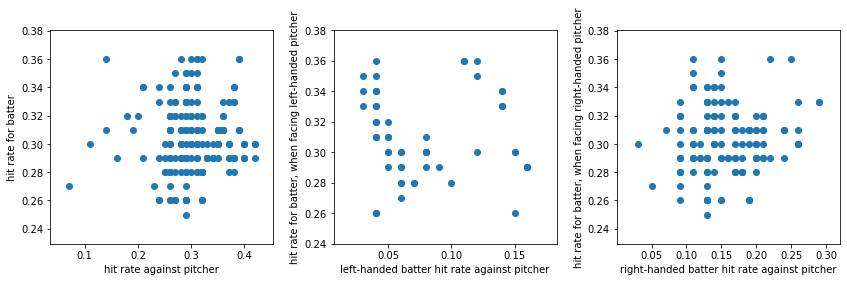

<IPython.core.display.Javascript object>

In [1473]:
# Hitter performance with pitcher performance - player 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(df_b_p_merged["prop_events_nback_bs"], df_b_p_merged["prop_events_nback"])
ax1.set_xlabel("hit rate against pitcher")
ax1.set_ylabel("hit rate for batter")

# Hits against left-handed pitchers, when facing a left-handed pitcher
df_b_p_merged_L = df_b_p_merged[df_b_p_merged["p_throws"] == 0].copy()
ax2.scatter(
    df_b_p_merged_L["prop_events_sum_nback_bs_L"], df_b_p_merged_L["prop_events_nback"]
)
ax2.set_xlabel("left-handed batter hit rate against pitcher")
ax2.set_ylabel("hit rate for batter, when facing left-handed pitcher")

# Hits against right-handed pitchers, when facing a right-handed pitcher
df_b_p_merged_R = df_b_p_merged[df_b_p_merged["p_throws"] == 1].copy()
ax3.scatter(
    df_b_p_merged_R["prop_events_sum_nback_bs_R"], df_b_p_merged_R["prop_events_nback"]
)
ax3.set_xlabel("right-handed batter hit rate against pitcher")
ax3.set_ylabel("hit rate for batter, when facing right-handed pitcher")
plt.tight_layout()

Text(0.5, 1.0, 'Player 1 (overall)')

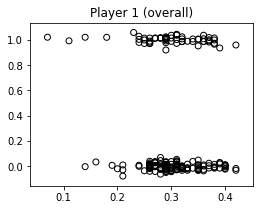

<IPython.core.display.Javascript object>

In [1474]:
f, (ax1) = plt.subplots(1, 1, figsize=(4, 3))
ax1.scatter(
    df_b_p_merged["prop_events_nback_bs"], df_b_p_merged["event_code"] + np.random.normal(0, 0.025, len(df4model_p1)),
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("Player 1 (overall)")


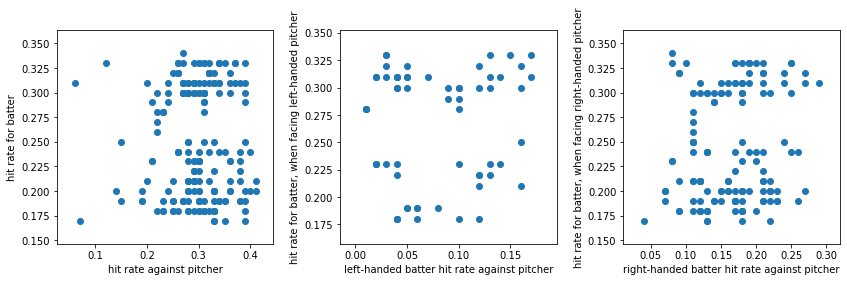

<IPython.core.display.Javascript object>

In [1475]:
# Hitter performance with pitcher performance - player 2

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(
    df_b_p_merged_p2["prop_events_nback_bs"], df_b_p_merged_p2["prop_events_nback"]
)
ax1.set_xlabel("hit rate against pitcher")
ax1.set_ylabel("hit rate for batter")

# Hits against left-handed pitchers, when facing a left-handed pitcher
df_b_p_merged_p2_L = df_b_p_merged_p2[df_b_p_merged_p2["p_throws"] == 0].copy()
ax2.scatter(
    df_b_p_merged_p2_L["prop_events_sum_nback_bs_L"],
    df_b_p_merged_p2_L["prop_events_nback"],
)
ax2.set_xlabel("left-handed batter hit rate against pitcher")
ax2.set_ylabel("hit rate for batter, when facing left-handed pitcher")

# Hits against right-handed pitchers, when facing a right-handed pitcher
df_b_p_merged_p2_R = df_b_p_merged_p2[df_b_p_merged_p2["p_throws"] == 1].copy()
ax3.scatter(
    df_b_p_merged_p2_R["prop_events_sum_nback_bs_R"],
    df_b_p_merged_p2_R["prop_events_nback"],
)
ax3.set_xlabel("right-handed batter hit rate against pitcher")
ax3.set_ylabel("hit rate for batter, when facing right-handed pitcher")
plt.tight_layout()

Text(0.5, 1.0, 'Player 2 (overall)')

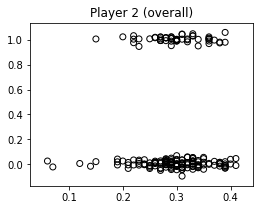

<IPython.core.display.Javascript object>

In [1476]:
f, (ax1) = plt.subplots(1, 1, figsize=(4, 3))
ax1.scatter(
    df_b_p_merged_p2["prop_events_nback_bs"],
    df_b_p_merged_p2["event_code"] + np.random.normal(0, 0.025, len(df4model_p1)),
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("Player 2 (overall)")

## Logistic regression

In [1477]:
X_train_scale_p1, X_test_scale_p1, y_train_p1, y_test_p1 = get_split_data(
    df_b_p_merged, 0.3
)
X_train_scale_p2, X_test_scale_p2, y_train_p2, y_test_p2 = get_split_data(
    df_b_p_merged_p2, 0.3
)

<IPython.core.display.Javascript object>

In [1478]:
df_b_p_merged.shape

(201, 7)

<IPython.core.display.Javascript object>

In [1479]:
print(X_train_scale_p1.shape, X_test_scale_p1.shape, y_train_p1.shape, y_test_p1.shape)
print(X_train_scale_p2.shape, X_test_scale_p2.shape, y_train_p2.shape, y_test_p2.shape)

(140, 6) (61, 6) (140,) (61,)
(140, 6) (61, 6) (140,) (61,)


<IPython.core.display.Javascript object>

In [1480]:
log_reg_p1_wp = LogisticRegression()
log_reg_p1_wp.fit(X_train_scale_p1, y_train_p1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [1481]:
y_pred_p1 = log_reg_p1_wp.predict(X_test_scale_p1)
y_predprob_p1 = log_reg_p1_wp.predict_proba(X_test_scale_p1)[:, 1]

<IPython.core.display.Javascript object>

In [1482]:
df_eval_p1 = pd.DataFrame(
    {"test": y_test_p1, "pred": y_pred_p1, "predprob": y_predprob_p1}
)
df_eval_p1.head()

,test,pred,predprob
40,1,0,0.315222
141,0,0,0.327202
33,0,0,0.296921
91,1,0,0.466917
13,0,0,0.260403


<IPython.core.display.Javascript object>

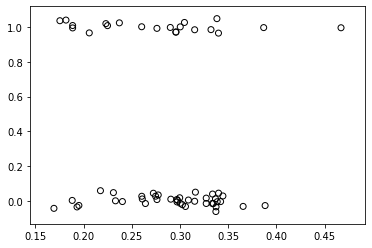

<IPython.core.display.Javascript object>

In [1483]:
f, ax1 = plt.subplots()

#
ax1.scatter(
    df_eval_p1["predprob"],
    df_eval_p1["test"] + np.random.normal(0, 0.025, len(df_eval_p1)),
    facecolors="none",
    edgecolors="black",
)

In [1484]:
log_reg_p1_wp.coef_

array([[-0.28088299,  0.06408509,  0.01514172,  0.20912622, -0.30236944,
        -0.59698024]])

<IPython.core.display.Javascript object>

In [1372]:
# print(
#     "low prob, 0: ", ((df_eval_p1["predprob"] < 0.29) & (df_eval_p1["test"] == 0)).sum()
# )
# print(
#     "low prob, 1: ", ((df_eval_p1["predprob"] < 0.29) & (df_eval_p1["test"] == 1)).sum()
# )
# print(
#     "high prob, 0: ",
#     ((df_eval_p1["predprob"] > 0.29) & (df_eval_p1["test"] == 0)).sum(),
# )
# print(
#     "high prob, 1: ",
#     ((df_eval_p1["predprob"] > 0.29) & (df_eval_p1["test"] == 1)).sum(),
# )

low prob, 0:  16
low prob, 1:  9
high prob, 0:  24
high prob, 1:  12


<IPython.core.display.Javascript object>

In [1011]:
# The number of right-handed pitchers matches the "high probability"
# X_test_p1["p_throws"].sum()

48

<IPython.core.display.Javascript object>

# Game condition features